# [NTDS'18] milestone 4: graph signal processing
[ntds'18]: https://github.com/mdeff/ntds_2018

[Rodrigo Pena](https://people.epfl.ch/254838), [EPFL LTS2](http://lts2.epfl.ch)

## Students

* Team: `6`
* Students: `Gabor Csordas`, `Maëlle Le Clainche`, `Nicolas Fontbonne`, `Marie Sadler`
* Dataset:`Flights routes`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to do some Graph Signal Processing (GSP) on the data of your project.

### A note about plotting

There are several questions in this milestone that ask you to plot a signal on your network.
There are several ways from which you could approach it.
In all cases, compute the position of the nodes a single time at the beginning, as this is likely to be a costly operation.
Using a single layout for all the graph plots will also make it easier to compare the plots.
Indeed, the only thing changing between plots is the signal displayed.
You can represent the features/labels lying on the graph via node **colors**.
To do so, make sure to have a consistent color map throughout and remember to display a colorbar and scale in all plots, so that we can tell what numbers the colors represent.

* An option is to use the **Laplacian eigenmaps** that you have seen in the previous milestone to embed your graph on the plane. For example:
  ```
  from matplotlib import pyplot as plt
  plt.scatter(eigenvectors[:, 1], eigenvectors[:, 2], c=signal, alpha=0.5)
  plt.colorbar()
  ```
* Another option is to use the plotting capabilities of **[NetworkX](https://networkx.github.io)**.
  See the documentation of its [drawing methods](https://networkx.github.io/documentation/stable/reference/drawing.html).
  For example:
  ```
  import networkx as nx
  graph = nx.from_scipy_sparse_matrix(adjacency)
  coords = nx.spring_layout(graph)  # Force-directed layout.
  coords = eigenvectors[:, 1:3]  # Laplacian eigenmaps.
  nx.draw_networkx_nodes(graph, coords, node_size=60, node_color=signal)
  nx.draw_networkx_edges(graph, coords, alpha=0.3)
  ```
* Another option is to use the plotting capabilities of the **[PyGSP](https://github.com/epfl-lts2/pygsp)**, a Python package for Graph Signal Processing.
  **Note that your are forbidden to use the PyGSP for anything else than plotting.**
  See the documentation of its [plotting utilities](https://pygsp.readthedocs.io/en/stable/reference/plotting.html).
  For example:
  ```
  import pygsp as pg
  graph = pg.graphs.Graph(adjacency)
  graph.set_coordinates('spring')  # Force-directed layout.
  graph.set_coordinates(eigenvectors[:, 1:3])  # Laplacian eigenmaps.
  graph.plot_signal(signal)
  ```
* Yet another option is to save your graph on disk, use **[Gephi](https://gephi.org)** externally, to visualize the graph, save the graph with the Gephi coordinates and finally load the nodes coordinates back into the notebook.

We encourage you to try all the above methods before making your choice. Then be consistent and use only one throughout the milestone.
NetworkX and PyGSP should already be installed in your environement. If that's not the case, install with `conda install networkx pygsp` (after activating the `ntds_2018` environment).

---


## 0 - Load your network

In [1]:
%matplotlib inline

*If you get a `No module named 'pyunlocbox'` error when running the below cell, install the [pyunlocbox](https://github.com/epfl-lts2/pyunlocbox) with `conda install pyunlocbox` (after activating the `ntds_2018` environment).*

In [1]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
from matplotlib import pyplot as plt
from pyunlocbox import functions, solvers
from sklearn.cluster import KMeans

*For this milestone, all we will need is a set of features/labels for each of the nodes on the network, as well as the Laplacian, $L,$ and Gradient, $\nabla_G,$ matrices that you have computed for your network while working on milestone 3.*

*Import those objects in the cell below (or recompute the Laplacian and Gradient from your stored adjacency matrix, if you wish).*

*Note: If your features/labels are not floating-point numbers, please convert them. For example, if your data has labels "cat" and "dog" for nodes that represent cats or dogs, respectively, you may assign the number `1.0` for the label "cat" and the number `-1.0` for the label "dog".*

In [2]:
adjacency =  np.load("adjacency_th.npy")
adjacency_unweighted = np.copy(adjacency)
adjacency_unweighted[adjacency_unweighted!=0]=1
degrees = np.sum(adjacency, axis = 0)
n_nodes = adjacency.shape[0]

adjacency_csr = sparse.csr_matrix(adjacency_unweighted);
degree_matrix_csc = sparse.diags(degrees,format = "csc");

laplacian_combinatorial_csr =  sparse.csr_matrix(degree_matrix_csc - adjacency_csr);
inv_degree_matrix_csr = sparse.linalg.inv(degree_matrix_csc).tocsr()
sqrt_inv_degree_matrix_csr = sparse.csr_matrix.sqrt(inv_degree_matrix_csr)
laplacian_normalized_csr = sqrt_inv_degree_matrix_csr * laplacian_combinatorial_csr * sqrt_inv_degree_matrix_csr;

n_edges = np.sum(degrees);
S = np.zeros((n_nodes, n_edges));
edge_cnt = 0;
for i in range(n_nodes):
    for j in range(n_nodes):
        if adjacency_unweighted[i,j] == 1:
            S[i,edge_cnt] = 1;
            S[j,edge_cnt] = -1;
            edge_cnt += 1;
            
L = (1/2)* S @ np.transpose(S)
print(laplacian_combinatorial_csr.toarray()[:10,:10])
print(L[:10,:10])

[[84. -1. -1. -1. -1. -1. -1. -1.  0.  0.]
 [-1. 30.  0. -1. -1. -1.  0.  0.  0.  0.]
 [-1.  0. 12. -1.  0. -1.  0.  0.  0.  0.]
 [-1. -1. -1. 64. -1. -1.  0. -1.  0.  0.]
 [-1. -1.  0. -1. 31. -1. -1. -1.  0.  0.]
 [-1. -1. -1. -1. -1. 34.  0.  0.  0.  0.]
 [-1.  0.  0.  0. -1.  0. 13. -1.  0.  0.]
 [-1.  0.  0. -1. -1.  0. -1. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 28.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 13.]]
[[84. -1. -1. -1. -1. -1. -1. -1.  0.  0.]
 [-1. 30.  0. -1. -1. -1.  0.  0.  0.  0.]
 [-1.  0. 12. -1.  0. -1.  0.  0.  0.  0.]
 [-1. -1. -1. 64. -1. -1.  0. -1.  0.  0.]
 [-1. -1.  0. -1. 31. -1. -1. -1.  0.  0.]
 [-1. -1. -1. -1. -1. 34.  0.  0.  0.  0.]
 [-1.  0.  0.  0. -1.  0. 13. -1.  0.  0.]
 [-1.  0.  0. -1. -1.  0. -1. 10.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0. 28.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0. 13.]]


In [3]:
laplacian = laplacian_normalized_csr.toarray()
gradient = np.transpose(S)

In [4]:
[eigenvalues, eigenvectors] = sparse.linalg.eigsh(laplacian_normalized_csr, k = n_nodes-1)
sortID = np.argsort(eigenvalues)
eigenvalues = eigenvalues[sortID]
eigenvectors = eigenvectors[:,sortID]
k = 3
d = 6
H = eigenvectors[:,:d]; 
labels = KMeans(n_clusters=k, random_state=0).fit_predict(H)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 2, 2,
       2, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2,
       2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,

In [5]:
for i in np.unique(labels):
    print ('Cluster',i,':',len(labels[np.where(labels==i)]))

Cluster 0 : 302
Cluster 1 : 102
Cluster 2 : 57


---

## 1 - Graph Fourier Transform

*In this section we will observe how your feature/label vector looks like in the "Graph Fourier" domain.*

### Question 1

*Compute the Fourier basis vectors and the Laplacian eigenvalues. Make sure to order those from smaller to larger, $\lambda_0 \leq \lambda_1 \leq \dots \leq \lambda_{N-1},$ and use the same ordering for the Fourier basis vectors.*

In [7]:
[eigenvalues, eigenvectors] = scipy.linalg.eigh(laplacian)
sortID = np.argsort(eigenvalues)
eigenvalues[eigenvalues < 10**(-10)] = 0
e = eigenvalues[sortID] # Ordered Laplacian eigenvalues

eigenvectors = eigenvectors[:,sortID]
#eigenvectors[eigenvectors < 10**(-10)] = 0
U = eigenvectors # Ordered graph Fourier basis.

#"the columns of matrix U are the eigenvectors of the Laplacian matrix", after 
# On the Graph Fourier Transform for Directed Graphs by Stefania Sardellitti

*Plot the first 3 and the last Fourier basis vectors as signals on your graph. Clearly indicate which plot belongs to which basis vector.*

In [9]:
import pygsp as pg
graph = pg.graphs.Graph(adjacency)
graph.set_coordinates('spring') 
plt.rcParams['figure.figsize'] = (20, 6)

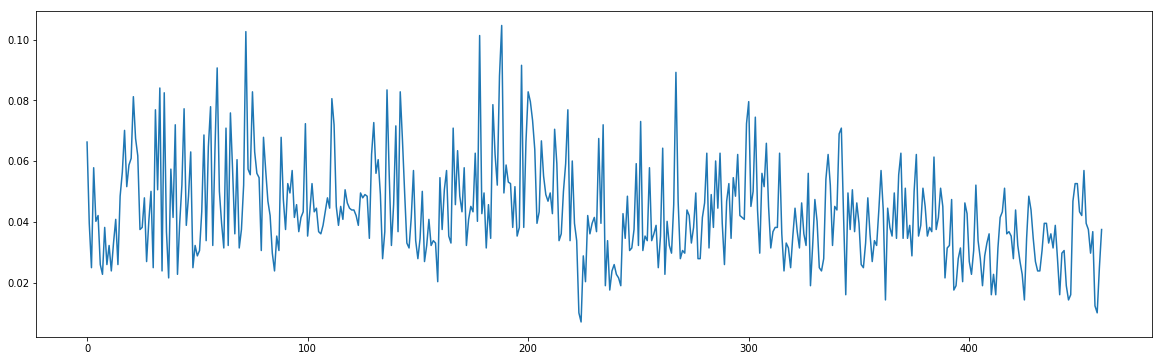

In [9]:
plt.plot(U[:,0])

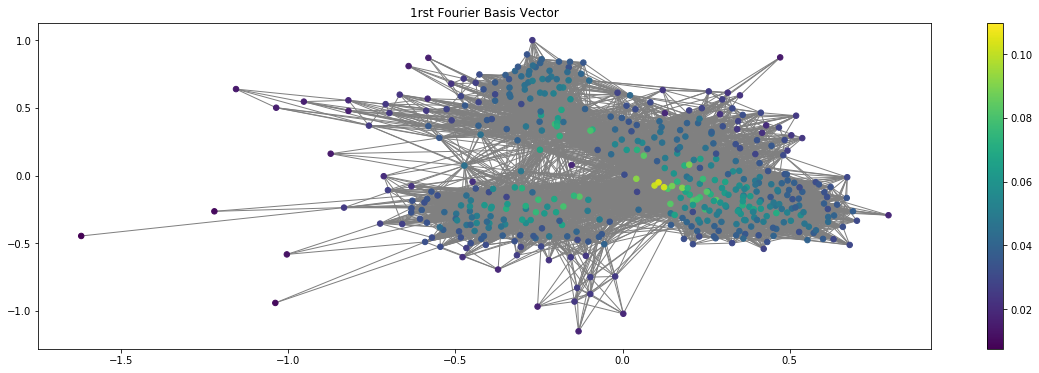

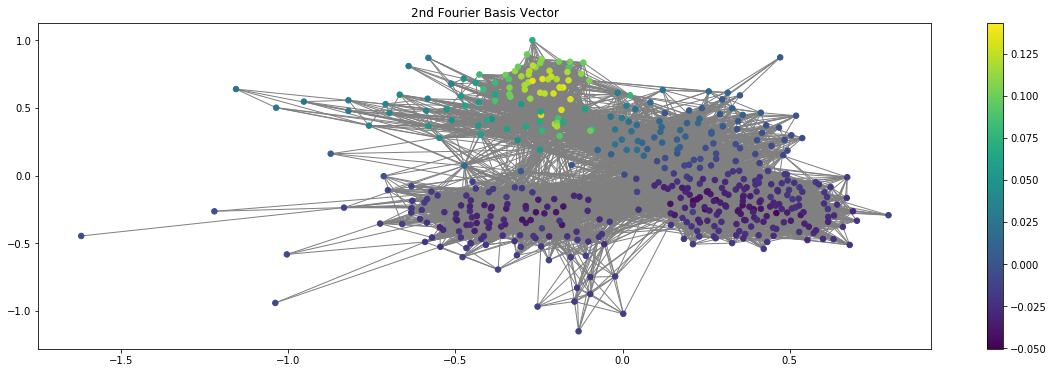

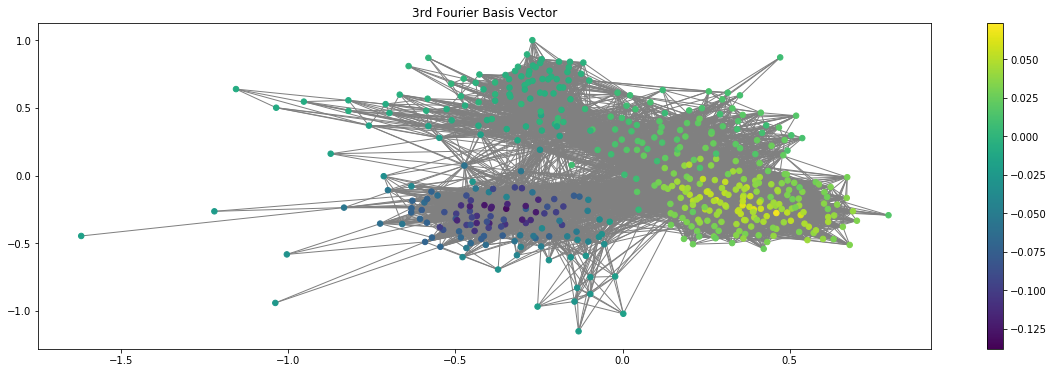

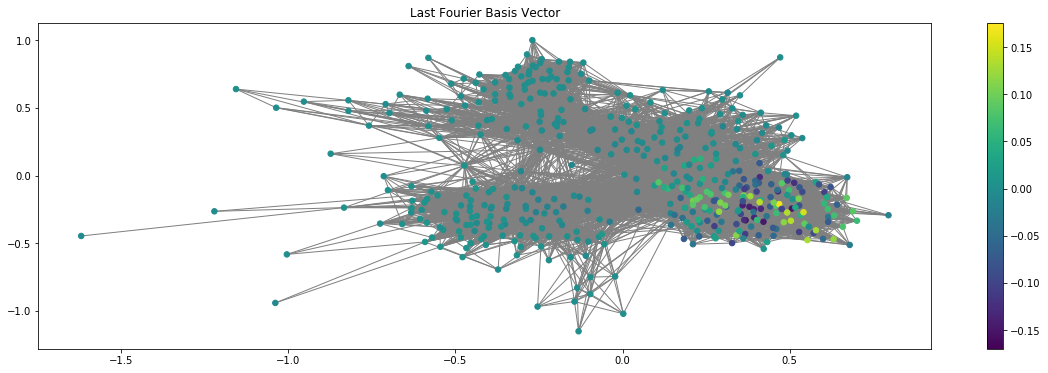

In [10]:
graph.plot_signal(U[:,0],vertex_size=30,plot_name='1rst Fourier Basis Vector')
graph.plot_signal(U[:,1],vertex_size=30,plot_name='2nd Fourier Basis Vector')
graph.plot_signal(U[:,2],vertex_size=30,plot_name='3rd Fourier Basis Vector')
graph.plot_signal(U[:,n_nodes-1],vertex_size=30,plot_name='Last Fourier Basis Vector')

### Question 2

*What can you observe in terms of local variations when comparing the basis vectors corresponding to the smallest eigenvalues to those corresponding to the largest eigenvalue? How would this justify the interpretation of the eigenvalues as "graph frequencies"?*

**Answer**

We can observe that the Fourier basis vectors corresponding to the smallest eigenvalues present smooth variations over the graph (U1 is smoother than U2, which is itself smoother than U3 ect), while the Fourier basis vectors corresponding to largest eigenvalues result in rough variations. Thus, the interpretation in terms of "graph frequencies" is : the first vectors are the low frequencies (slow variation), and the last vectors are the high frequencies (fast variation).

### Question 3

*Implement a function that returns the Graph Fourier Transform (GFT) of a given vector $x \in \mathbb{R}^{N},$ with respect to your graph, and a function that computes the corresponding inverse GFT (iGFT).*

In [11]:
def GFT(x): #equation 3 of course paper
    # x must be of size n_nodes !
    x_out=np.zeros(n_nodes)
    for l in range (0,n_nodes): #number of vectors in U 
        for i in range (1,n_nodes): #size of each vector of U
            x_out[l]=x_out[l]+x[i]*np.conjugate(U[i][l])
    return x_out

def iGFT(x): #equation 4 of course paper
    # x must be of size n_nodes !
    x_out=np.zeros(n_nodes)
    for i in range (0,n_nodes):  #size of each vector of U
        for l in range (0,n_nodes): #number of vectors in U
            x_out[i]=x_out[i]+x[l]*U[i][l]
    return x_out

### Question 4

*Plot your feature/label vector as a signal on your graph*

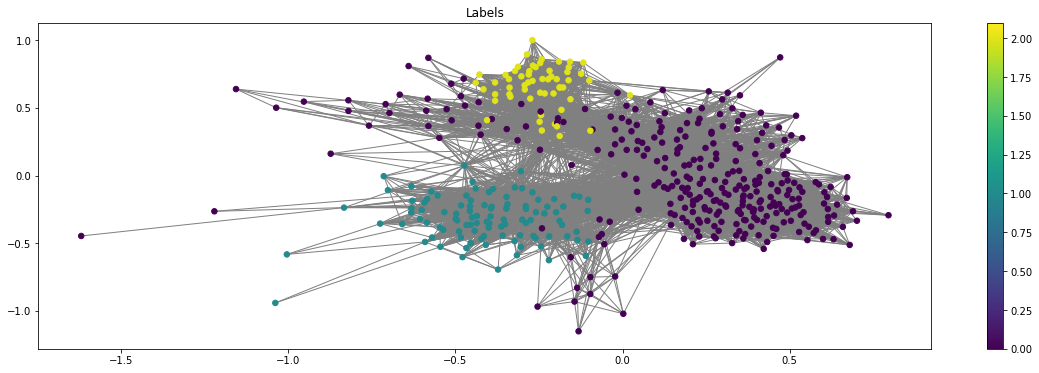

In [12]:
graph.plot_signal(labels,vertex_size=30,plot_name='Labels')

*Plot the absolute values of the GFT of your feature/label signal as a function of the graph eigenvalues. Make sure to add a marker indicating the position of each graph eigenvalue, and remember to properly name the axes.*

Text(0, 0.5, 'Absolute values of the label signal GFT')

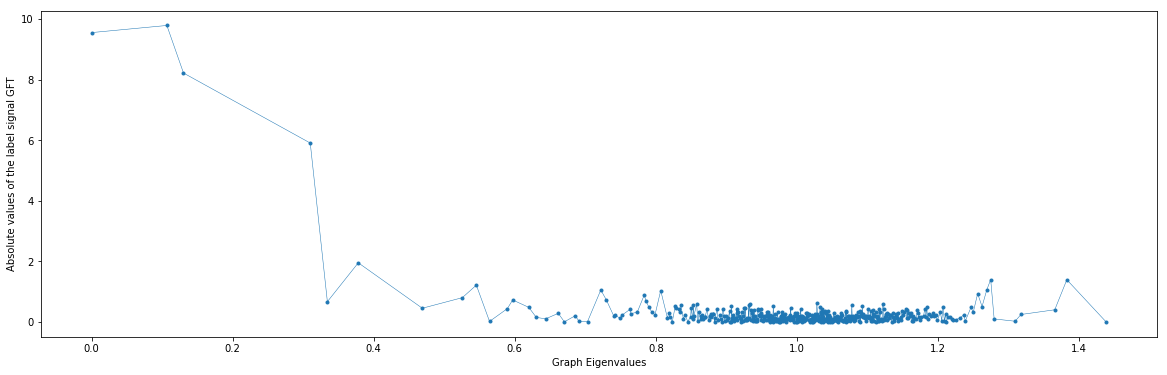

In [13]:
labels_TF=GFT(labels)

plt.plot(e,abs(labels_TF), marker='.', linewidth=0.5)
plt.xlabel('Graph Eigenvalues')
plt.ylabel('Absolute values of the label signal GFT')

### Question 5

*Discuss the behavior of the GFT that you plotted in the last question via comparing the plot of your label signal and those of the Fourier basis of Question 1. Would you consider your labels a "low-pass" or "high-pass" signal, or yet something else entirely?*

**Answer**

According to the plot before, our labels are a low pass filter, with a cut frequency at around 0.4 in terms of eigenvalues. This is expected, because when looking at our labels on the graph, we see that the repartition is quite close to U1 (and of course to U0 and U2, because they are not that different), and that can explain why the second eigenvalue corresponds to the higher absolute value of the label signal GFT.

---
## 2 - Filtering on graphs

*In this section we will check how filtered Dirac impulses diffuse on your graph.*

### Question 6 

Implement the following three filter kernels and the graph filtering operation.

- The **heat kernel** is supposed to take in a vector of eigenvalues `e` and a parameter `t` and output a vector of evaluations of the heat kernel at those eigenvalues (see the course slides for help).
- The **inverse filter** kernel is supposed to take in a vector of eigenvalues `e` and a parameter `t` and implement spectrally the  filter defined in the node domain by $f_{out}  = (I + t L)^{-1} f_{in},$ where $f_{in}, f_{out} \in \mathbb{R}^{N}$ are, repectively, the input and output signals to the filter.
- The **rectangle kernel** takes in a vector of eigenvalues `e` and parameters `l_min` and `l_max` and returns `1.0` at coordinates satisfying $(e[l] \geq l_{min}) \wedge (e[l] \leq l_{max}),$ and `0.0` otherwise.
- The **graph filtering** operation takes a graph signal $x \in \mathbb{R}^{N}$, a spectral graph `kernel` and a set of keyworded variables, and returns the corresponding filtered signal.
    - _Hint:_ Remember that you have implemented the `GFT` and `iGFT` operations in Question 3.
    - The `**kwargs` is a placeholder to collect supplementary pairs of keyword-values that are not known by the implementation before execution time.
      The `kwargs` variable is a dictionary whose keyes and values are the parameter names and values.
      This is useful to allow both `graph_filter(x, heat_kernel, tau=1.0)` and `graph_filter(x, rectangle_kernel, lambda_min=0.0, lambda_max=1.0)` to be valid calls from the same implementation.
      One can then defer the keyword-value assignment to the `kernel` call: `foo = kernel(bar, **kwargs)`.

In [14]:
def heat_kernel(e, t): #in node domain
    f_out=np.exp(-t*e)
    return f_out

def inverse_kernel(e, t): #in node domain
    f_out=1/(1+t*e)
    return f_out

def rectangle_kernel(e, l_min, l_max): #in node domain
    f_out=e.copy() #vector of size of e
    for l in range (0,len(e)):
        if ((e[l]>=l_min) and e[l]<=l_max) :
            f_out[l]=1.0
        else :
            f_out[l]=0.0
    return f_out

def graph_filter(x, kernel, **kwargs):
    # take the foo
    foo=kernel(e,**kwargs) 
    #take the Fourier Transform
    x_FT=GFT(x)
    #Filter
    f_out_FT=x_FT*foo
    #iFT
    f_out=iGFT(f_out_FT)    
    return f_out

### Question 7

*Plot all three filter kernels in the spectral domain. Remember to properly name the axes and title the plots. Choose filter parameters that best approximate the behavior of the GFT of your feature/label signal (as seen in Question 4).*

Text(0, 0.5, 'Kernel Values')

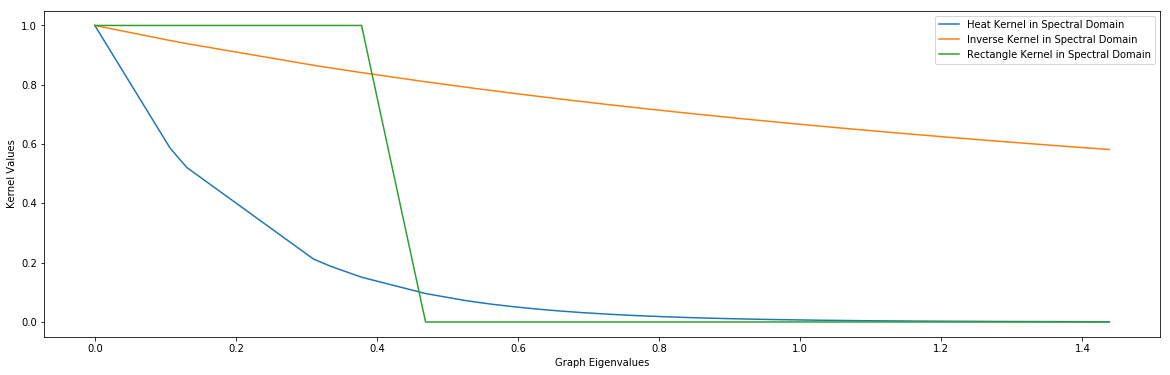

In [15]:
# Parameters 
t=5#first try
l_min=0
l_max=0.4

# Plot
plt.figure()
plt.plot(e,heat_kernel(e,t), label='Heat Kernel in Spectral Domain')
plt.plot(e,inverse_kernel(e,0.5), label='Inverse Kernel in Spectral Domain')
plt.plot(e,rectangle_kernel(e,l_min,l_max), label='Rectangle Kernel in Spectral Domain')
plt.legend()
plt.xlabel('Graph Eigenvalues')
plt.ylabel('Kernel Values')

### Question 8

*Consider two Dirac impulses arbitrarily placed on your graph. Plot their filtered versions by the three filter kernels implemented in Question 6.*

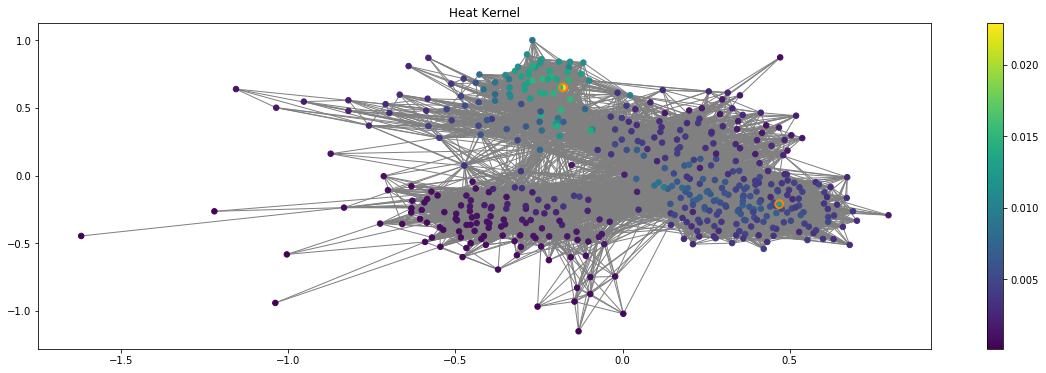

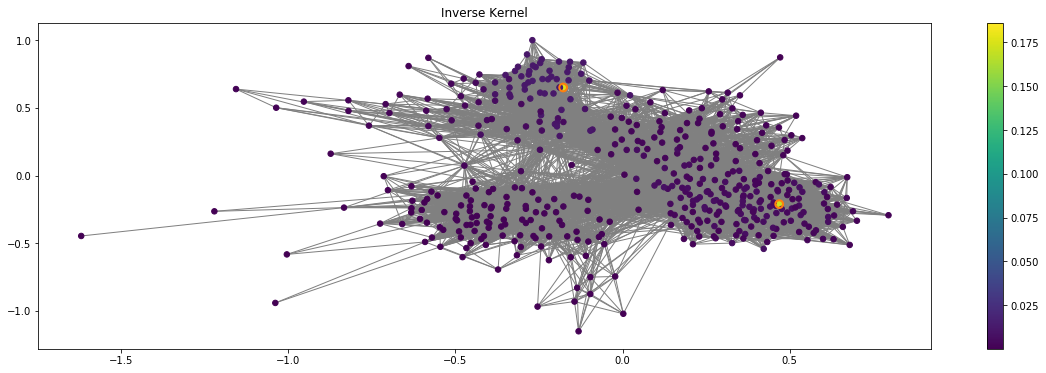

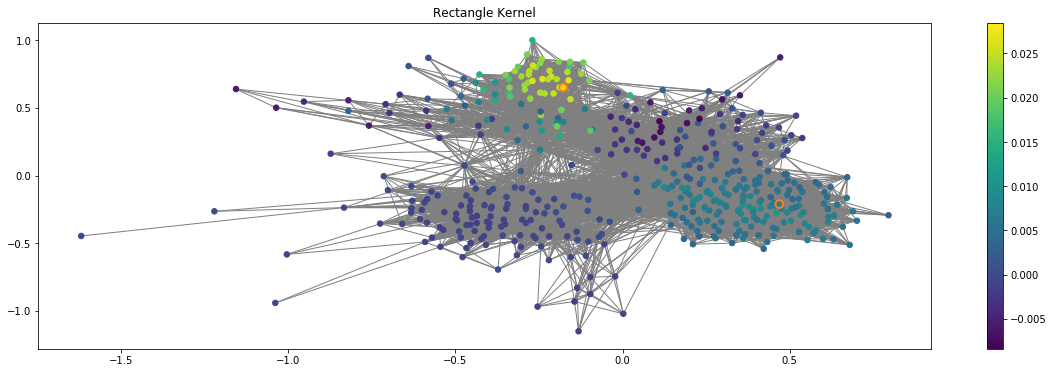

In [16]:
#Reminder : A "Dirac delta" function is a function that is zero everywhere except at one point

#creating 2 random deltas position
deltas=[np.random.randint(0,n_nodes), np.random.randint(0,n_nodes)]

#creating signal
f=np.zeros(n_nodes)
f[deltas]=1

# filter
res1 = graph_filter(f, heat_kernel, t=5)
res2 = graph_filter(f, inverse_kernel, t=5)
res3 = graph_filter(f, rectangle_kernel, l_min=0, l_max=0.4)
#Plot
graph.plot_signal(res1, highlight=deltas,vertex_size=30,plot_name='Heat Kernel' )
graph.plot_signal(res2, highlight=deltas,vertex_size=30,plot_name='Inverse Kernel')
graph.plot_signal(res3, highlight=deltas,vertex_size=30,plot_name='Rectangle Kernel')

*Comment on the "diffusion" of the Diracs induced by the filters. What does it say about the "communication" of information across your network? Relate that to the network connectivity measures that you analyzed during the previous milestones.*

**Answer**
* The heat kernel spreads mostly around the dirac center. The points far away from it are not affected. This is expected since we have seen in the previous question, that the heat kernel is a smooth low pass filter, which with our parameters, cuts at a frequency of around 0.4.

* The inverse kernel is putting each node of our graph to the same level : this is because it is an "all pass" with our parameters.

* The rectangle kernel is a rough low pass filter, with a cut frequency at 0.4 (according to our chosen parameters). In this case we see that the diffusion goes from the deltas to the exterior, but with more details at the exterior than for the heat kernel (because the heat kernel GFT shows that it decreases faster).

* These graphs, and especially the one resulting from the rectangle kernel filter, show different "layouts" for the communication. In the rectangle kernel filter, we can count 8 colors (counting the dirac) : this corresponds to the number of connected components in our graph !

---

## 3 - De-noising

*In this section we will add some centered Gaussian noise to your feature/label signal and attempt to recover it.*

### Question 9

*In the cell below, set the noise variance $\sigma^2$ by making sure that the signal-to-noise ratio $SNR = \frac{\operatorname{Var}(\text{labels})}{\sigma^2}$ is about  $1.5$.*

*_Note:_ Actually, you might want to play with the noise variance here and set it to different values and see how the denoising filters behave.*

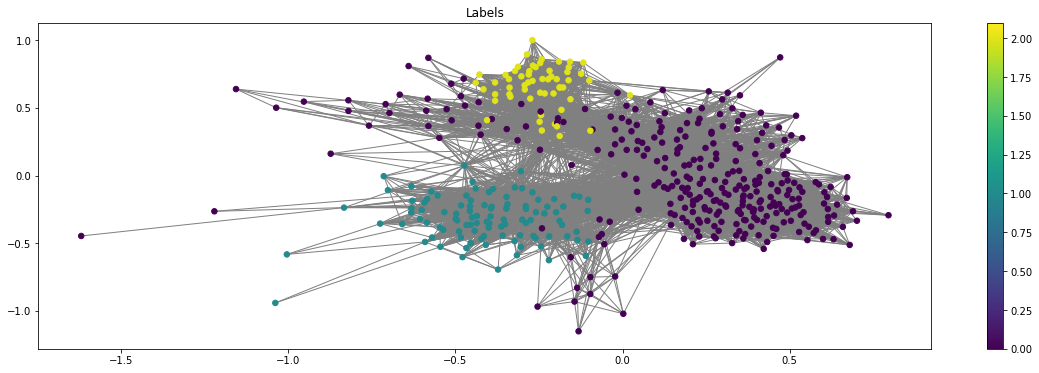

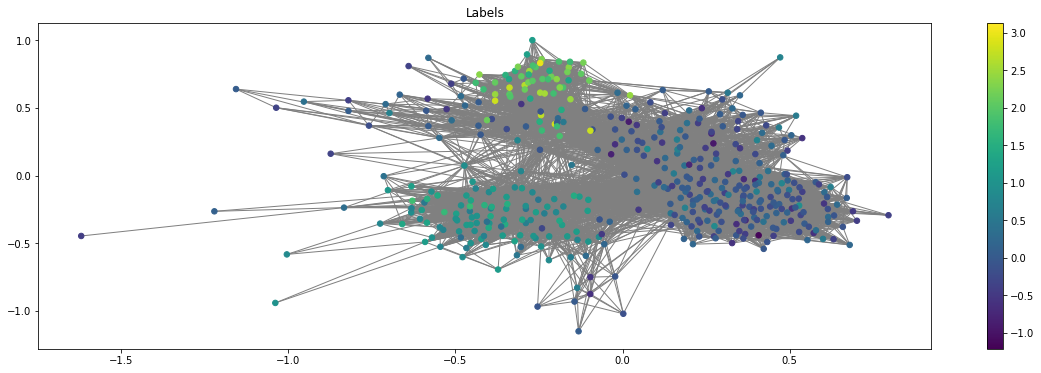

In [17]:
snr = 1.5
noise_variance = np.var(labels)/snr # Your code here.
noisy_measurements = labels + noise_variance * np.random.randn(n_nodes)

graph.plot_signal(labels,vertex_size=30,plot_name='Labels')
graph.plot_signal(noisy_measurements,vertex_size=30,plot_name='Labels')

### Question 10

*In the denoising setting, a common graph signal processing assumption is that the signal $z$ that we want to recover is "smooth", in the sense that $\|\nabla_G z\|_2 = \sqrt{z^{\top} L z}$ is small, while remaining "close" to the measurements that we start with. This leads to denoising by solving the following optimization problem:*

$$
z^\star = \text{arg} \, \underset{z \in \mathbb{R}^{N}}{\min} \, \|z - y\|_2^2 + \gamma z^{\top} L z, 
$$

*where $y \in \mathbb{R}^{N}$ is the vector of noisy measurements.*

*Derive the close form solution to this problem giving $z^\star$ as a function of $y$, $\gamma$ and $L$. Does this solution correspond to any graph filtering operation that you know?*

**Answer**

The solution of this equation is given putting it derivative equals to zero (as the function is convex).
$$
z^\star - y + \gamma L z^\star = 0
$$

$$
(I + \gamma L) z^\star = y
$$

$$
 z^\star = (I + \gamma L)^{-1}y
$$

It is the inverse filter kernel that we computed in `question 6`.

By taking the Graph Fourier Transform on the previous equations we have :

$$
\hat{z^\star}(i) + \gamma \hat{Lz^\star}(i) = \hat{y}(i)
$$
For each eigenvector $u_i$ associated with the eigenvalue $\lambda_i$ we have (because $L$ is symetric):
$$
u_i^TLz^\star = u_i^TL^Tz^\star = (Lu_i)^Tz^\star = \lambda_iu_i^Tz^\star
$$
Therefore :
$$
\hat{z^\star}(i) + \gamma \lambda_i\hat{z^\star}(i) = \hat{y}(i)
$$
And finally:
$$
\hat{z^\star}(i)= \frac{1}{1+\lambda_i}\hat{y}(i)
$$
which is the well knowed formula of a low pass filter in the Fourier domain. Solving this optimization problem come back to a simple low pass filtering.

### Question 11

*Now, denoise the noisy measurements by passing them through the filters that you implemented in Question 6. Choose the filter parameters based on the behavior of the GFT of your original label signal (this is the prior knowledge that you input to the problem).*

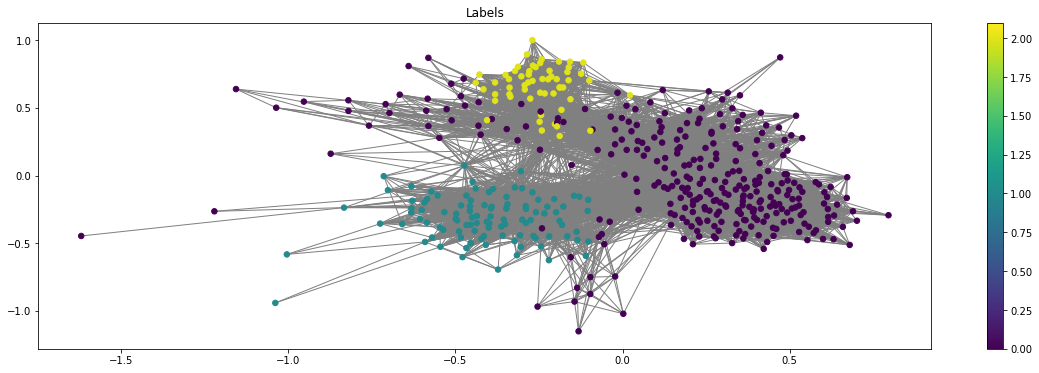

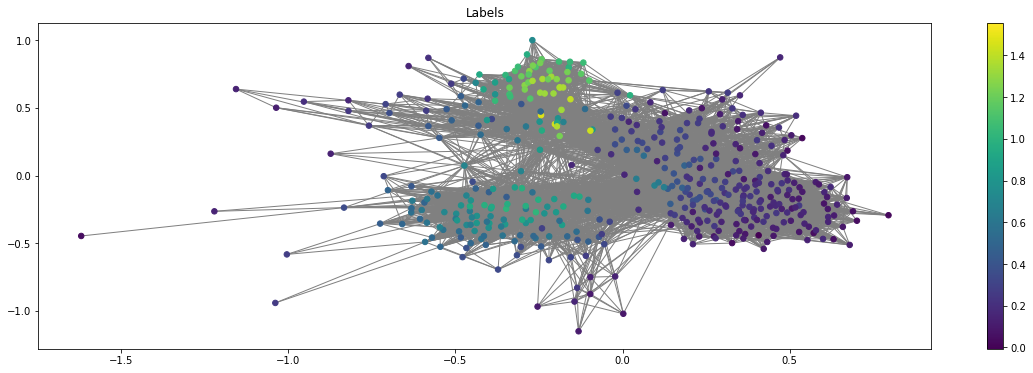

In [18]:
#plt.plot(e,abs(GFT(labels)),label = "Pure")
#plt.plot(e,abs(GFT(noisy_measurements)), label="Noisy")

#z_heat_denoised = # Your code here.
z_inv_denoised = graph_filter(noisy_measurements, inverse_kernel, t=8)# Your code here.
#plt.plot(e,abs(GFT(z_inv_denoised)),label = "Denoised")
#plt.legend()
graph.plot_signal(labels,vertex_size=30,plot_name='Labels')
graph.plot_signal(z_inv_denoised,vertex_size=30,plot_name='Labels')
#z_rect_denoised = graph_filter(f, rectangle_kernel, l_min=0, l_max=0.8)# Your code here.
#graph.plot_signal(z_rect_denoised,vertex_size=30,plot_name='Rectangle Kernel')

*Plot, on your graph, the original label signal, the noisy measurements, and the three denoised version obtained above. Report on each plot the value of the corresponding relative error*
$$
\text{rel-err} = \frac{\|\text{labels} - z \|_2}{\|\text{labels}\|_2},
$$
*where $z$ is the plotted signal.*

In [19]:
# Your code here.
# The function of the rel-err is already in question 15

Finally, overlay on the same plot the GFT of all five signals above.

In [20]:
# Your code here.

### Question 12

Comment on which denoised version seems to best match the original label signal. What is the underlying assumption behind the three filtering approaches? Do you think it holds for your label signal? Why?

# **Your answer here.**

---

## 4 - Transductive learning

*It is often the case in large networks that we can only afford to query properties/labels on a small subset of nodes. Nonetheless, if the underlying labels signal is "regular" enough, we might still be able to recover a good approximation of it by solving an offline variational problem, with constraints on the values of the measured nodes.*

*In this section, we will be interested in solving such transductive learning problems by minimizing a (semi-) p-norm of the graph gradient applied to the signal of interest:*

$$
\text{arg} \, \underset{z|_S = y}{\min} \|\nabla_G z\|_p^p,
$$

*where $S$ is the set of measured nodes.*

*In English, we can say that we are looking for solutions with small "aggregated local variations", as measured by $\|\nabla_G z\|_p^p = \sum_{i=1}^{n} \sum_{j=1}^{n} \left( \sqrt{W_{ij}} |z[i] - z[j]| \right)^p,$ while satisfying the measurement constraints $z[i] = y[i]$ for $i \in S.$*

*We will work with two cases, according to the choices $p=1$ or $p=2.$ For $p=1,$ the problem is known as "interpolation by graph total-variation minimization," whereas for $p=2$ it is sometimes called "interpolation by Tikhonov regularization".*

*In order to solve these variational problems with the black-box solver provided to you, you will use the [pyunlocbox](https://pyunlocbox.readthedocs.io). This toolbox implements iterative solvers based on so-called ["proximal-splitting"](https://en.wikipedia.org/wiki/Proximal_gradient_method) methods.*

### Question 13

*Throughout this section, we will consider only a binarized version of your label signal. If your variable `labels` currently has values other than $\{-1, 1\},$ threshold them so that those are the only values taken in this vector. This can be done for example by choosing a number $t \in \mathbb{R}$ and then setting $\text{labels_bin}[i] = 1$ if $\text{labels}[i] \geq t$ and $\text{labels_bin}[i] = 0$ otherwise.*

In [6]:
# create a binary labeling, with labels equaling 2 being converted to 1
labels_bin = labels.copy()
labels_bin[labels_bin == 2] = 1
# labels equaling 0 are converted to -1
labels_bin[labels_bin == 0] = -1

*Now, subsample this binarized label signal by $70\%$ by choosing, uniformly at random, $30\%$ of the nodes whose labels we will keep.*

*You will do this by computing a "measurement mask" vector `w` with `1.0`'s at the measured coordinates, and $0.0$'s otherwise.*

In [7]:
mn_ratio = 0.3

m = int(mn_ratio * n_nodes)  # Number of measurements.
# create a vector with m times 1, distributed at random
w = np.array([1] * m + [0] * (n_nodes-m))
np.random.shuffle(w)

*Plot the subsampled signal on the graph. _Hint:_ you might want to set to `numpy.nan` the values of the un-measured nodes for a cleaner plot.*

/Users/Marie/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
/Users/Marie/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)


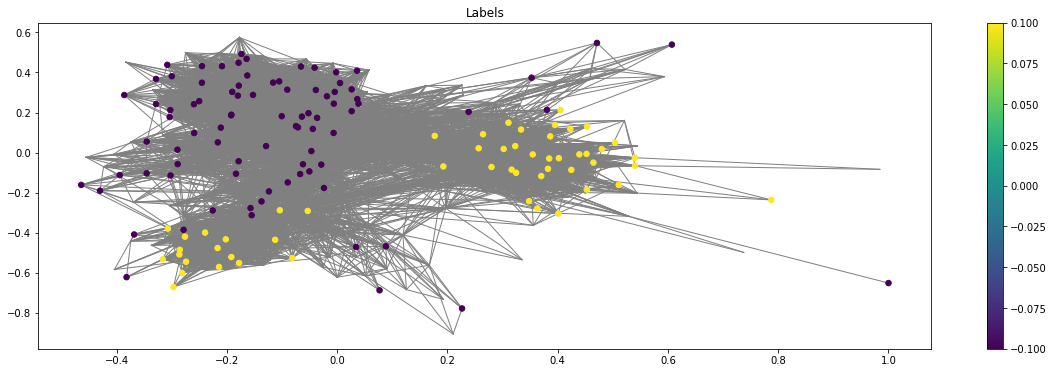

In [10]:
labels_bin_plt = labels_bin.astype(np.float).copy()
labels_bin_plt[w==0] = np.nan
graph.plot_signal(labels_bin_plt,vertex_size=30,plot_name='Labels')

### Interlude

*For the solution of the variational problems you can use the following function as a "black-box".* 

*You will just need to provide a `gradient` matrix (which you should already have from Section 0), and an orthogonal projection operator `P` onto the span of the measured coordinates (made precise in the next question).*

In [11]:
def graph_pnorm_interpolation(gradient, P, x0=None, p=1., **kwargs):
    r"""
    Solve an interpolation problem via gradient p-norm minimization.

    A signal :math:`x` is estimated from its measurements :math:`y = A(x)` by solving
    :math:`\text{arg}\underset{z \in \mathbb{R}^n}{\min}
    \| \nabla_G z \|_p^p \text{ subject to } Az = y` 
    via a primal-dual, forward-backward-forward algorithm.

    Parameters
    ----------
    gradient : array_like
        A matrix representing the graph gradient operator
    P : callable
        Orthogonal projection operator mapping points in :math:`z \in \mathbb{R}^n` 
        onto the set satisfying :math:`A P(z) = A z`.
    x0 : array_like, optional
        Initial point of the iteration. Must be of dimension n.
        (Default is `numpy.random.randn(n)`)
    p : {1., 2.}
    kwargs :
        Additional solver parameters, such as maximum number of iterations
        (maxit), relative tolerance on the objective (rtol), and verbosity
        level (verbosity). See :func:`pyunlocbox.solvers.solve` for the full
        list of options.

    Returns
    -------
    x : array_like
        The solution to the optimization problem.

    """
    
    grad = lambda z: gradient.dot(z)
    div = lambda z: gradient.transpose().dot(z)

    # Indicator function of the set satisfying :math:`y = A(z)`
    f = functions.func()
    f._eval = lambda z: 0
    f._prox = lambda z, gamma: P(z)

    # :math:`\ell_1` norm of the dual variable :math:`d = \nabla_G z`
    g = functions.func()
    g._eval = lambda z: np.sum(np.abs(grad(z)))
    g._prox = lambda d, gamma: functions._soft_threshold(d, gamma)

    # :math:`\ell_2` norm of the gradient (for the smooth case)
    h = functions.norm_l2(A=grad, At=div)

    stepsize = (0.9 / (1. + scipy.linalg.norm(gradient, ord='fro'))) ** p

    solver = solvers.mlfbf(L=grad, Lt=div, step=stepsize)

    if p == 1.:
        problem = solvers.solve([f, g, functions.dummy()], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    if p == 2.:
        problem = solvers.solve([f, functions.dummy(), h], x0=x0, solver=solver, **kwargs)
        return problem['sol']
    else:
        return x0

### Question 14

*During the iterations of the algorithm used for solving the variational problem, we have to make sure that the labels at the measured nodes stay the same. We will do this by means of an operator `P` which, given a vector $a \in \mathbb{R}^{N},$ returns another vector $b \in \mathbb{R}^{N}$ satisfying $b[i] = \text{labels_bin}[i]$ for every node $i$ in the set $S$ of known labels, and $b[i] = a[i]$ otherwise. Write in the cell below the function for this orthogonal projection operator `P`.*

*_Hint:_ remember you have already computed the mask `w`.*

In [12]:
def P(a):
    b = a.copy()
    b[w==1] = labels_bin[w==1]
    return b

### Question 15

*Solve the variational problems for $p = 1$ and $p = 2$. Record the solution for the $1-$norm minimization under `sol_1norm_min` and the one for $2-$norm minimization under `sol_2norm_min`.*

*Compute also binarized versions of these solutions by thresholding the values with respect to $0$, that is, non-negative values become `1.0`, while negative values become `-1.0`. Store those binarized versions under `sol_1norm_bin` and `sol_2norm_bin`, respectively.*

In [13]:
# initialize x0
x0 = np.zeros(n_nodes)

In [14]:
sol_1norm_min = graph_pnorm_interpolation(gradient, P, x0=x0, p=1.)
sol_2norm_min = graph_pnorm_interpolation(gradient, P, x0=x0, p=2.)

sol_1norm_bin = np.sign(sol_1norm_min)
sol_2norm_bin = np.sign(sol_2norm_min)

Solution found after 3 iterations:
    objective function f(sol) = 8.210243e+03
    stopping criterion: RTOL
Solution found after 196 iterations:
    objective function f(sol) = 6.490598e+03
    stopping criterion: RTOL


*Plot, on your graph, the original `labels_bin` signal, as well as the solutions to the variational problems (both binarized and otherwise). Indicate on each plot the value of the relative error $\text{rel-err} = \frac{\|\text{labels_bin} - z\|_2}{\|\text{labels_bin}\|_2}$, where $z$ is the signal in the corresponding plot.*

In [18]:
def rel_err(ref, test):
    return np.round(np.linalg.norm(ref-test)/np.linalg.norm(ref), 3)

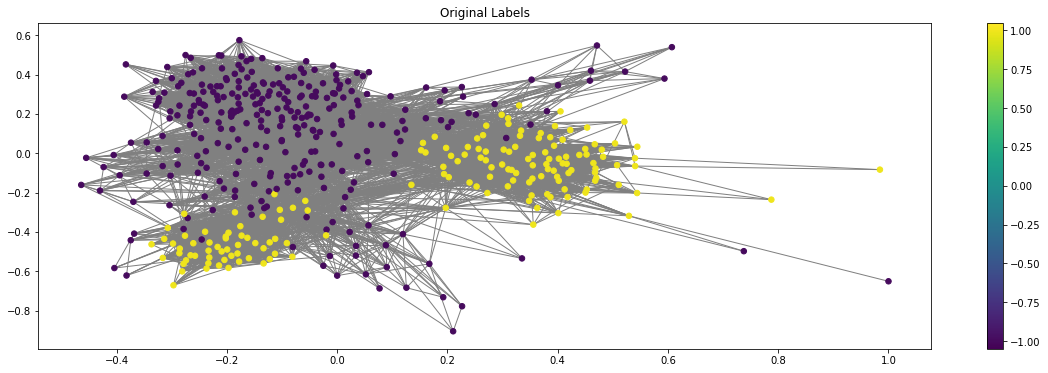

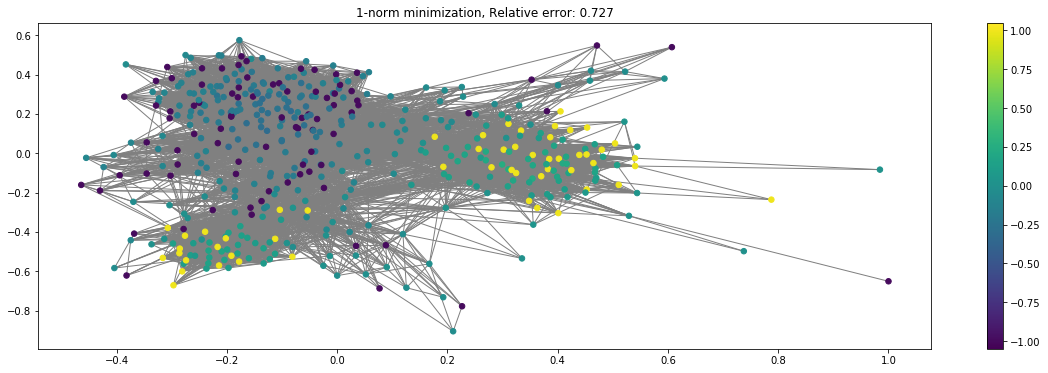

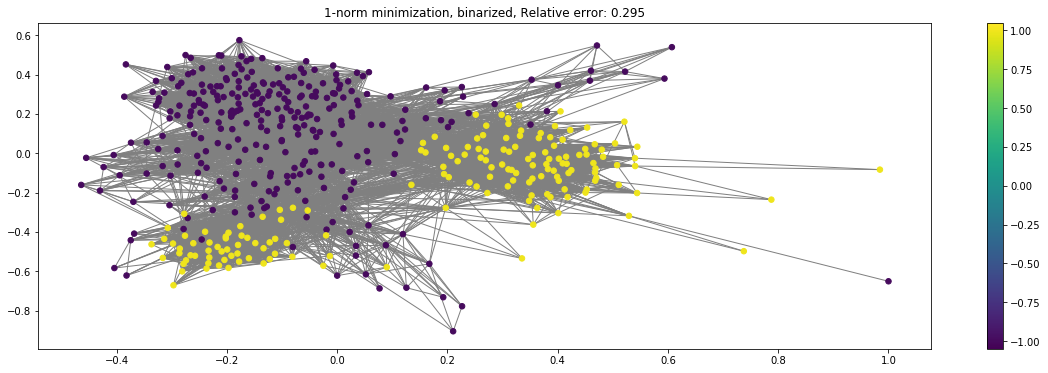

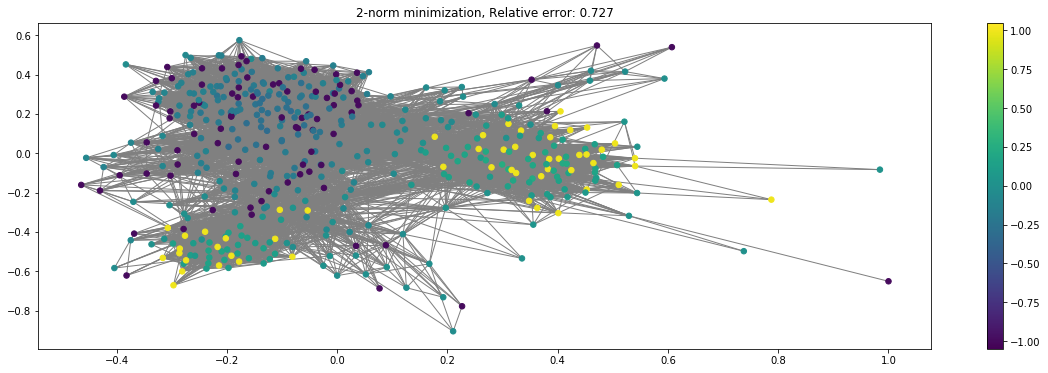

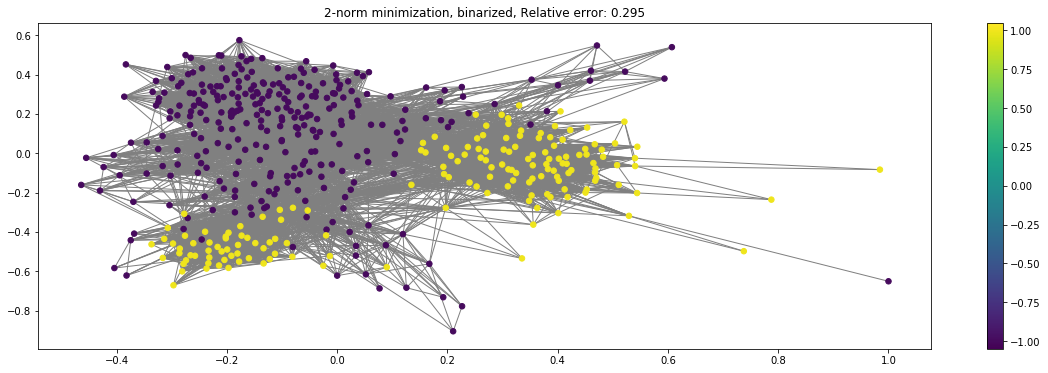

In [21]:
graph.plot_signal(labels_bin,vertex_size=30,plot_name='Original Labels')
graph.plot_signal(sol_1norm_min,vertex_size=30,plot_name='1-norm minimization, Relative error: ' + str(rel_err(labels_bin, sol_1norm_min)))
graph.plot_signal(sol_1norm_bin,vertex_size=30,plot_name='1-norm minimization, binarized, Relative error: ' + str(rel_err(labels_bin, sol_1norm_bin)))
graph.plot_signal(sol_2norm_min,vertex_size=30,plot_name='2-norm minimization, Relative error: ' + str(rel_err(labels_bin, sol_2norm_min)))
graph.plot_signal(sol_2norm_bin,vertex_size=30,plot_name='2-norm minimization, binarized, Relative error: ' + str(rel_err(labels_bin, sol_2norm_bin)))

### Question 16

*Now that you have got a feeling for the sort of solutions that the transductive learning problems studied can give, we will see what is the effect of the number of measurements on the accuracy of both $p-$norm minimization problems.*

*Towards this goal, you will write a `phase_transition()` function. This function will basically go over all the procedures that you have implemented in this section, but for varying numbers of measurements and thresholding values. It will also compute the relative error, $\text{rel-err},$ of the solutions and average them over a number of trials.*

*The output of the `phase_transition()` function has to be a matrix with `len(mn_ratios)` columns and `len(thresholds)` rows. Each pixel $(i,j)$ in the output matrix has to contain the average, over `n_trials` trials, of the relative error $\text{rel-err}$ in the binarized (with threshold `thresholds[i]`) solution given by `graph_pnorm_interpolation()` from observing an `mn_ratios[j]` fraction of nodes. The randomness comes from a different choice of mask `w` at each trial, hence the averaging.*

*The interest of this phase transition matrix is to assess what level of recovery error one could expect for a certain fraction of measurements and a certain threshold level.*

In [22]:
def phase_transition(mn_ratios, thresholds, n_trials, labels_bin, p):
    pt_matrix = np.zeros([len(thresholds), len(mn_ratios)])
    x0 = np.zeros(n_nodes)
    trials = np.zeros(n_trials)
    
    for j, mn_ratio in enumerate(mn_ratios):
        # Create sample mask.
        m = int(mn_ratio * n_nodes)
        w = np.array([1] * m + [0] * (n_nodes-m))
        for k in range(n_trials):
            # Solve p-norm interpolation.
            for i, threshold in enumerate(thresholds):
                np.random.shuffle(w)
                sol_min = graph_pnorm_interpolation(gradient, P, x0=x0, p=p, verbosity = 'NONE')
                sol_bin = np.sign(sol_min-threshold) # if val == threshold -> val = 1
                # Aggregate.
                pt_matrix[i, j] += rel_err(labels_bin, sol_bin)
    
    return pt_matrix/n_trials

### Question 17

*Pick 5 "m/n" ratios in $(0, 1)$ and 5 threshold levels in $(-1, 1)$ and run the `phase_transition()` function with `n_trials` = 20, for both $p = 1$ and $p = 2$.*

In [23]:
mn_ratios = np.linspace(n_nodes/5, n_nodes - n_nodes/5, 5)/n_nodes

thresholds = np.linspace(-1, 1, 5)

n_trials = 20

pt_matrix_1norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, 1)

pt_matrix_2norm = phase_transition(mn_ratios, thresholds, n_trials, labels_bin, 2)

*Plot both phase transition matrices as images with a colorbar. Make sure to properly name the axes and title the images.*

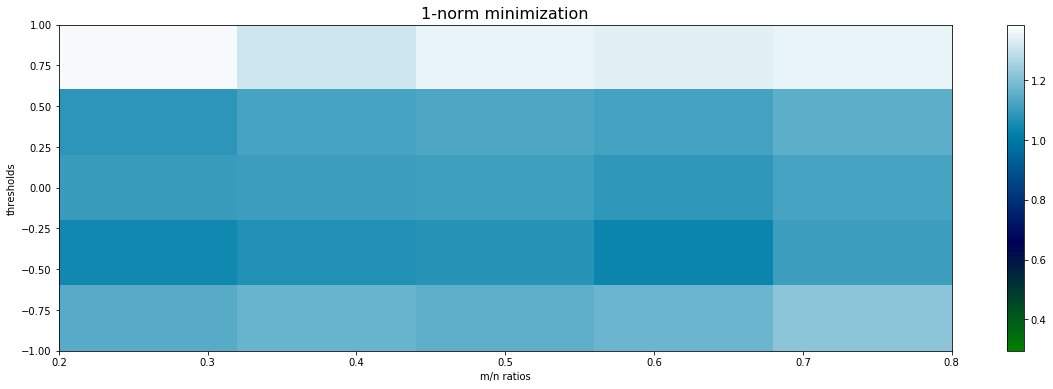

In [35]:
vmin = np.min(np.concatenate((pt_matrix_1norm, pt_matrix_2norm)))
vmax = np.max(np.concatenate((pt_matrix_1norm, pt_matrix_2norm)))
plt.imshow(pt_matrix_1norm, interpolation='nearest', cmap=plt.cm.ocean, vmin=vmin, vmax=vmax, aspect="auto", extent = [mn_ratios[0], mn_ratios[-1],thresholds[0],thresholds[-1]])
plt.xlabel("m/n ratios")
plt.ylabel("thresholds")
plt.title('1-norm minimization', fontsize = 16)
plt.colorbar()

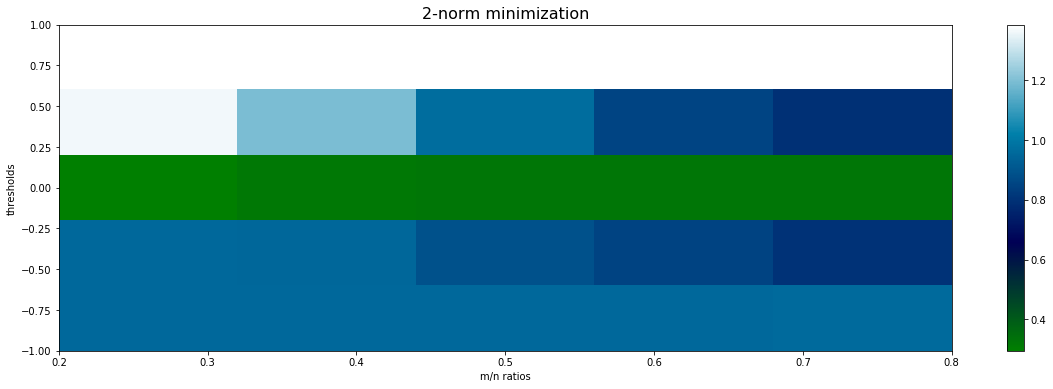

In [36]:
plt.imshow(pt_matrix_2norm, interpolation='nearest', cmap=plt.cm.ocean, vmin=vmin, vmax=vmax, aspect="auto",  extent = [mn_ratios[0], mn_ratios[-1],thresholds[0],thresholds[-1]])
plt.xlabel("m/n ratios")
plt.ylabel("thresholds")
plt.title('2-norm minimization', fontsize = 16)
plt.colorbar()

### Question 18

*Do the phase transition plots above provide any justification for choosing one $p-$norm interpolation over the other? Why?*

**Answer**

From the phase transition plots we see that the relative error does not change significantly for different parameters using the 1-norm interpolation. On the other hand, the 2-norm interpolation is much more sensitive, especially with regards to the threshold value. 

To get the best results, we would choose the 2-norm interpolation, since it provides a lower relative error (for an optimal set of parameters) than the 1-norm interpolation. 